# **Analyse de sentiments sur les films du TOP 100 box office (Notebook principal)**
**Projet Python - 2A ENSAE**

AUMONT Louis-Armand, KHAIRALDIN Ahmed, GIMENES Vincent

## Introduction

L'objectif de ce Notebook va être de: 
+ **1)** charger la base de données, puis nettoyer les commentaires pour les "tokenisés" et enfin les "lemmatisés"
+ **2)** appliquer des algorithmes de NLP sur nos commentaires "lemmatisés" afin de déduire pour chaque commentaire un score de polarité
+ **3)** Procéder à une analyse de statistique descriptive avec nos variables et visualiser des relations entre elles
+ **4)** Modéliser pour tenter d'analyser les relations entre nos variables (linéaires, quadratiques), si pas de relation apparente, tester statistiquement la non-corrélation


### Traitement des données et analyse de sentiments

Avant de pouvoir faire de l'analyse de sentiment pour chaque commentaire, il faut d'abord les nettoyer pour les rendre lisibles pour l'ordinateur. Premièrement, nous allons transformer le fichier data_reviews en une base de données où chaque observation est un commentaire. Puis, nous allons nettoyer chaque commentaire en utilisant des fonctions permettant de supprimer la ponctuation, les stop-words et la lemmatisation.



####  Download Library ⚙️

In [1]:
#pip install spacy
#!pip install wordcloud
#!pip install textblob

####  Import Library 📦

In [39]:
# Importation de packages nécessaires

import pandas as pd
import json
import nltk
import spacy
import matplotlib.pyplot as plt
import seaborn as sns 

# Style
sns.set_style('darkgrid')

from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer

In [3]:
# Téléchargement d'éléments nécessaires à la tokenisation
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Download the VADER lexicon for sentiment analysis
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /Users/louis-
[nltk_data]     armandaumont/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/louis-
[nltk_data]     armandaumont/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/louis-
[nltk_data]     armandaumont/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /Users/louis-
[nltk_data]     armandaumont/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

## **1.** Création de la base de données des commentaires

### **1.1** Création du DataFrame

In [4]:
# Transformation du fichier json en un Dataframe Pandas

# Charger le fichier JSON
with open("data_reviews.json", 'r') as file:
    data = json.load(file)

In [5]:
movie_name = []
comments = []
notes = []
year= []
budget=[]
recette=[]
duree=[]

for movie, dico in data.items():
    if '0' in dico and isinstance(dico['0'], list):  # Vérifier si la clé '0' est une liste
        for comment in dico['0']:
            movie_name.append(movie)
            comments.append(comment)
            year.append(dico['1'])
            notes.append(dico['2'])
            budget.append(dico['3'])
            recette.append(dico['4'])
            duree.append(dico['5'])

df = pd.DataFrame({
    'Film': movie_name,
    'Commentaire': comments,
    'Annee':year,
    'Note imdb': notes,
    'Budget':budget,
    'Box office':recette,
    'duree':duree
})

df.sample(5)

,Film,Commentaire,Annee,Note imdb,Budget,Box office,duree
12209,Harry Potter et l'Ordre du Phénix (2007),This fifth installment in the Harry Potter fra...,2007,"7,5",150000000,939288806,2h 18m
7238,Toy Story 3 (2010),I've seen a lot of disappointing three-quels i...,2010,"8,3",200000000,1067316101,1h 43m
12886,Harry Potter et la Chambre des secrets (2002),The books by J. K. Rowling narrating Harry Pot...,2002,"7,4",100000000,926201000,2h 41m
9807,Jumanji : Bienvenue dans la jungle (2017),I've seen the original movie once or twice as ...,2017,"6,9",90000000,995339117,1h 59m
14674,Star Wars : Épisode III - La Revanche des Sith...,It is unquestionable that this is the best ent...,2005,"7,6",113000000,868390560,2h 20m


### **1.2** Nettoyage des commentaires

#### **1.2.1** Tokenisation et suppression de la ponctuation

Il faut executer la cellule ci-dessous pour pouvoir charger le modèle de la langue anglaise de scapy.

In [6]:
# permet d'afficher un commentaire même si il est très long
pd.set_option('display.max_colwidth', None)

In [7]:
#oOn retire les "\n" dans les commentaires
df["Commentaire"] = df["Commentaire"].str.replace('\n','')
df["Commentaire"].sample()

15760    No this is not a movie. Oversimplistic plot, zero character development, zero acting. Why did they bring all this great actors? for nothing! Why did they need oscars' Kate Blanchett for a superficial villain who just kills a few people? What did the presence of Matt Damon, Benedict Cumberbatch, Karl Urban added to the movie? Nothing! A few scenes, a few lines to make a couple of jokes and that's it. Idris Elba could bring some dramatic effect, but no. I can go like that for the rest.Yes some images are beautiful (although much less than previous movie, the pair Thor - Loki had some nice opportunities, but even them seemed too fake, too one-liners, too child acting. Even when delivering some 1st grade jokes they did it so badly.Marvel continues its own Ragnarok. Maybe they target the youngest audience in purpose to ensure future gains, or the silliest. Just look at the positive reviews, they either venerate Marvel as a perfect God, or their reviews are similar to the movie's ch

In [8]:
pd.set_option('display.max_colwidth', 100)

In [9]:
#!python3 -m spacy download en_core_web_sm

In [10]:
# On commence par charger le modèle de la langue anglaise de Spacy (les commentaires sont en anglais)
nlp = spacy.load('en_core_web_sm')

# Fonction qui prend en argument un commentaire (chaîne de caractère) et qui retourne une liste des tokens sans les stopwords et la ponctuation
def tokenize(text):
    doc = nlp(text)
    tokens = [token.text for token in doc if not token.is_stop and not token.is_punct]
    return tokens

In [11]:
%%time
# On crée une nouvelle colonne avec la liste des tokens pour chaque commentaire
df['Tokens'] = df['Commentaire'].apply(tokenize)
df.sample(5)

CPU times: user 13min 21s, sys: 1min 6s, total: 14min 27s
Wall time: 15min 6s


,Film,Commentaire,Annee,Note imdb,Budget,Box office,duree,Tokens
2363,La Reine des Neiges 2 (2019),"Not as good as the first, the story is a bit flatter without surprise. But the graphics and musi...",2019,"6,8",150000000,1453683476,1h 43m,"[good, story, bit, flatter, surprise, graphics, music, amazing]"
11952,Le Monde de Nemo (2003),"I'm not a big fan of animation. In fact, up until I saw Finding Nemo, I had never seen an animat...",2003,"8,2",94000000,941637960,1h 40m,"[big, fan, animation, fact, saw, Finding, Nemo, seen, animated, film, love, seen, changed, vivac..."
2041,Top Gun: Maverick (2022),I'll preface my review by first stating that I had mediocre expectations coming in. It's very ha...,2022,"8,3",170000000,1495696292,2h 10m,"[preface, review, stating, mediocre, expectations, coming, hard, successful, sequel, older, clas..."
12564,Shrek 2 (2004),The original was a smart outlook on classic Hans Christian Andersen stories with a modern spice ...,2004,"7,3",150000000,928760770,1h 33m,"[original, smart, outlook, classic, Hans, Christian, Andersen, stories, modern, spice, added, pr..."
794,Star Wars : Épisode VII - Le Réveil de la Force (2015),J.J Abrams has without a doubt constructed and delivered the best Star Wars film since Return of...,2015,"7,8",245000000,2071310218,2h 18m,"[J.J, Abrams, doubt, constructed, delivered, best, Star, Wars, film, Return, Jedi, Better, best,..."


Avec Spacy, l'algortihme s'exécute en près de 11 min pour l'ensemble de la base de données. Nous avons utilisé Spacy et non nltk pour la tokenization et la suppression des stopwords, puisque Spacy a un répertoire plus important de stopwords et a de meilleures performances pour les textes volumineux.

#### **1.2.2** Lemmatisation des commentaires   
Nous allons désormais procéder à la lemmatisation des commentaires pour pouvoir allèger les algorithmes de NLP plus tard.

In [12]:
# Fonction qui prend en argument une liste de tokens et qui retourne ces tokens lemmatisés
def lemm(tokens):
    # D'abord, on transforme la liste en doc Spacy
    tokens_as_doc = spacy.tokens.Doc(nlp.vocab, words=tokens)
    # Lemmatisation du doc 
    lemmatized = [token.lemma_ for token in tokens_as_doc]
    return lemmatized
# Le lemma_ de Spacy ne reconnait pas les tokens et renvoie des listes vides (Pourquoi ?)

lemmatizer = WordNetLemmatizer()

def lemm2(tokens):
    lemmatized = [lemmatizer.lemmatize(token) for token in tokens]
    return lemmatized



In [13]:
# On crée une nouvelle colonne des tokens lemmatisés
df['Tokens lemmatisés'] = df['Tokens'].apply(lemm2)
df.sample(5)

,Film,Commentaire,Annee,Note imdb,Budget,Box office,duree,Tokens,Tokens lemmatisés
95,Avatar (2009),"3D graphics, 1D story. Great special effects, but that is about it. The story is basic, cheesy a...",2009,"7,9",237000000,2923706026,2h 42m,"[3D, graphics, 1D, story, Great, special, effects, story, basic, cheesy, predictable, like, mean...","[3D, graphic, 1D, story, Great, special, effect, story, basic, cheesy, predictable, like, meant,..."
3363,Star Wars : Épisode VIII - Les Derniers Jedi (2017),Absolute crap.Enough plot holes to sink the Titanic. Suspension of belief disrupted more than on...,2017,"6,9",317000000,1334407706,2h 32m,"[Absolute, crap, plot, holes, sink, Titanic, Suspension, belief, disrupted, Characters, act, pla...","[Absolute, crap, plot, hole, sink, Titanic, Suspension, belief, disrupted, Characters, act, plac..."
1428,Jurassic World (2015),"One thing that would be 100% guaranteed prior to the release of Jurassic World, is that whatever...",2015,"6,9",150000000,1671537444,2h 4m,"[thing, 100, guaranteed, prior, release, Jurassic, World, quality, lack, notices, mixed, reactio...","[thing, 100, guaranteed, prior, release, Jurassic, World, quality, lack, notice, mixed, reaction..."
3393,Star Wars : Épisode VIII - Les Derniers Jedi (2017),"When a movie goes against what people think they want and know about the star wars universe, the...",2017,"6,9",317000000,1334407706,2h 32m,"[movie, goes, people, think, want, know, star, wars, universe, complain, change, fact, objective...","[movie, go, people, think, want, know, star, war, universe, complain, change, fact, objectively,..."
11253,Doctor Strange in the Multiverse of Madness (2022),"Doctor Strange 2 is the MCU's latest balls-to-the-wall crossover event, and it's noticeably not ...",2022,"6,9",200000000,955775804,2h 6m,"[Doctor, Strange, 2, MCU, latest, balls, wall, crossover, event, noticeably, Spider, Man, Way, H...","[Doctor, Strange, 2, MCU, latest, ball, wall, crossover, event, noticeably, Spider, Man, Way, Ho..."


### **1.3** Représentation des mots

Maintenant, visualisons pour certains commentaires les mots les plus représentés après nettoyage des commentaires.

Commençons d'abord par visualiser un premier nuage de mots d'un commentaire quelconque.

In [14]:
# Fonction qui prend en argument une liste de tokens et qui retourne le nuage de mots correspondant.

def cloud(tokens):
    text = " ".join(tokens)
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
    return wordcloud

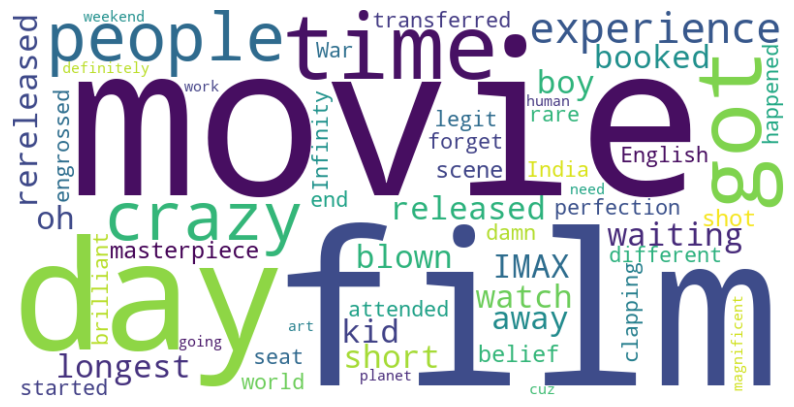

In [15]:
plt.figure(figsize=(10, 8))
plt.imshow(cloud(df['Tokens lemmatisés'][0]), interpolation='bilinear')
plt.axis("off")
plt.show()

Par exemple, pour le premier commentaire de la bdd, on peut dès à présent avoir une idée sur son avis vis à vis du film grâce à ce nuage de mots, de par la présence de mots tels que 'masterpiece, 'magnificent', 'perfection'... qui sont assez représentés. Néanmoins, comme nous avons utilisé nltk, le lemmatiseur ne reconnait pas les entités nommés telles que 'IMAX', 'India'... .

## **2.** NLP et analyse de sentiments

In [16]:
#Convertir les commentaires en string.
def string_function(column):
    return column.str.lower()

df['Commentaire'] =  string_function(df["Commentaire"])

Nous allons comparer les différents algorithmes proposés, notamment ceux des modules TextBlob, nltk et scapy.

On va dans un premier temps utiliser le module TextBlob

In [17]:
def analyze_sentiment_blob(tokens):
    text = ' '.join(tokens)
    blob = TextBlob(text)
    return blob.sentiment.polarity

In [18]:
# Appliquez la fonction à la colonne 'tokens_lemmatized' du DataFrame
df['sentiment_polarity_blob'] = df['Tokens lemmatisés'].apply(analyze_sentiment_blob)

On essaye maintenant avec la fonction SentimentIntensityAnalyzer de nltk

In [19]:
def analyze_sentiment_nltk(tokens):
    text = ' '.join(tokens)
    sia = SentimentIntensityAnalyzer()
    return sia.polarity_scores(text)['compound']

In [20]:
%%time
df['sentiment_polarity_nltk'] = df["Tokens lemmatisés"].apply(analyze_sentiment_nltk)

CPU times: user 3min 39s, sys: 2.64 s, total: 3min 42s
Wall time: 4min 5s


On essaye enfin de faire de l'analyse de sentiment avec le module scapy.

La fonction ci-dessus ne fonctionne pas bien puisqu'elle retourne que des 0. Je la laisse au cas où on trouve le problème.

Les notes et les années sont sous forme de string. Nous changeons cela pour pourvoir faire des statistiques avec.

In [21]:
df.dtypes

Film                        object
Commentaire                 object
Annee                       object
Note imdb                   object
Budget                      object
Box office                  object
duree                       object
Tokens                      object
Tokens lemmatisés           object
sentiment_polarity_blob    float64
sentiment_polarity_nltk    float64
dtype: object

In [22]:
#change le type de la colonne 'Note imdb' en float
df['Note imdb'] = df['Note imdb'].str.replace(',', '.').astype(float)
df['Annee'] = df['Annee'].astype(float)
df["Budget"] = df["Budget"].astype(float)
df['Box office'] = df["Box office"].astype(float)

On groupe les observations selon le film.

In [23]:
grouped = df.groupby('Film')
df_grouped = grouped[["sentiment_polarity_nltk", "sentiment_polarity_blob",  'Note imdb', 'Annee', "Budget", "Box office"]].mean()

Il peut être interessant de regarder aussi la variance des scores

In [24]:
var_by_group = grouped[["sentiment_polarity_nltk", "sentiment_polarity_blob"]].var()

In [25]:
correlation = mean_by_group['sentiment_polarity_nltk'].corr(mean_by_group['Note imdb'])
print(f"La correlation entre les notes sur imbd et la moyenne des scores de la polarité des sentiments par film évalué avec la library nltk est de {correlation}")

NameError: name 'mean_by_group' is not defined

In [ ]:
correlation = mean_by_group['sentiment_polarity_blob'].corr(mean_by_group['Note imdb'])
print(f"La correlation entre les notes sur imbd et la moyenne des scores de la polarité des sentiments par film évalué avec la library textblob est de {correlation}")

La correlation entre les notes sur imbd et la moyenne des scores de la polarité des sentiments par film évalué avec la library textblob est de 0.519272018770084


In [ ]:
correlation = mean_by_group['sentiment_polarity_nltk'].corr(mean_by_group['sentiment_polarity_blob'])
print(f"La correlation entre la moyenne des scores de la polarité des sentiments par film évalué avec la library nltk et la moyenne des scores de la polarité des sentiments par film évalué avec la library textblob est de {correlation}")

La correlation entre la moyenne des scores de la polarité des sentiments par film évalué avec la library nltk et la moyenne des scores de la polarité des sentiments par film évalué avec la library textblob est de 0.7549503705343742


Il y a une relation positive non négligeable entre les notes et le score des commentaires. Il y a également une forte corrélation entre les scores évalués par textblob et ceux évalués par nltk.

## **3.** Etude statistique du DataFrame

Nous allons séparer l'étude de notre DataFrame en deux temps:
- En premier lieu, analyse des variables numériques
- En second lieu, analyse statistique des commentaires

### **3.1** Variables numérique   
En premier lieu, on va regarder le type des variables de notre DataFrame afin de différencier les variables catégoriques, continues et textuelles

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17889 entries, 0 to 17888
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Film                     17889 non-null  object 
 1   Commentaire              17889 non-null  object 
 2   Annee                    17889 non-null  float64
 3   Note imdb                17889 non-null  float64
 4   Budget                   17889 non-null  float64
 5   Box office               17889 non-null  float64
 6   duree                    17889 non-null  object 
 7   Tokens                   17889 non-null  object 
 8   Tokens lemmatisés        17889 non-null  object 
 9   sentiment_polarity_blob  17889 non-null  float64
 10  sentiment_polarity_nltk  17889 non-null  float64
dtypes: float64(6), object(5)
memory usage: 1.5+ MB


#### **3.1.1** Les notes

Text(0.5, 1.0, 'Répartition des notes moyennes des films de notre échantillon')

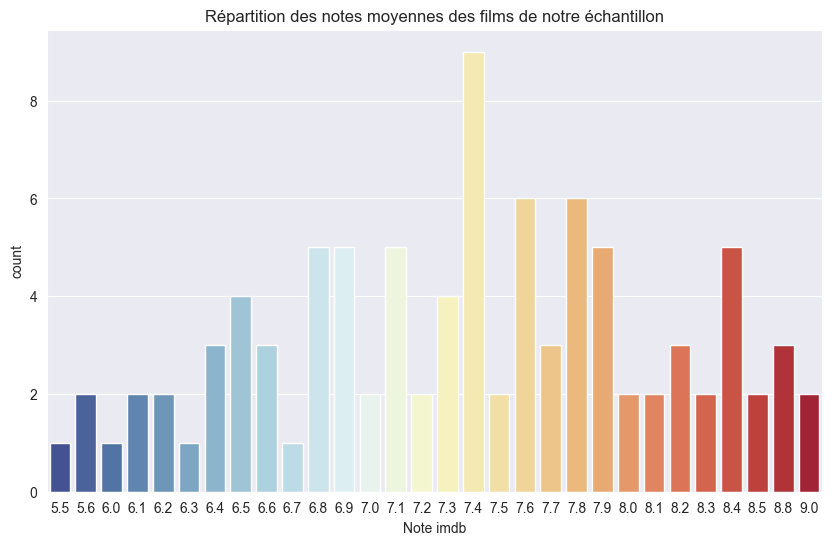

In [51]:
# Répartition de la note moyenne sur notre échantillon de 100 films
plt.figure(1, (10,6))
sns.countplot(x=df.groupby('Film')['Note imdb'].mean(), palette="RdYlBu_r")
plt.title('Répartition des notes moyennes des films de notre échantillon')

Les notes de notre échantillons semblent bien réparties en dans l'intervalle [5.5, 9.0], avec une forte concentration autour de 7.4, qui est la moyenne des notes de notre échantillon. 
La note minimale pour un film du top 100 sur IMDB est 5.5. La perfection ne semble pas atteignable aux yeux des spectateurs car la note maximale attribuée est de 9.0.

Nous allons maintenant nous intéresser à la distribution de ces notes.

/var/folders/mh/pjql7z356jb4v12kd0zhljs40000gn/T/ipykernel_3972/408035775.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x=df.groupby('Film')['Note imdb'].mean(),kde=True, bins=30, palette="RdYlBu_r")


Text(0.5, 1.0, 'Distribution des notes moyennes des films de notre échantillon')

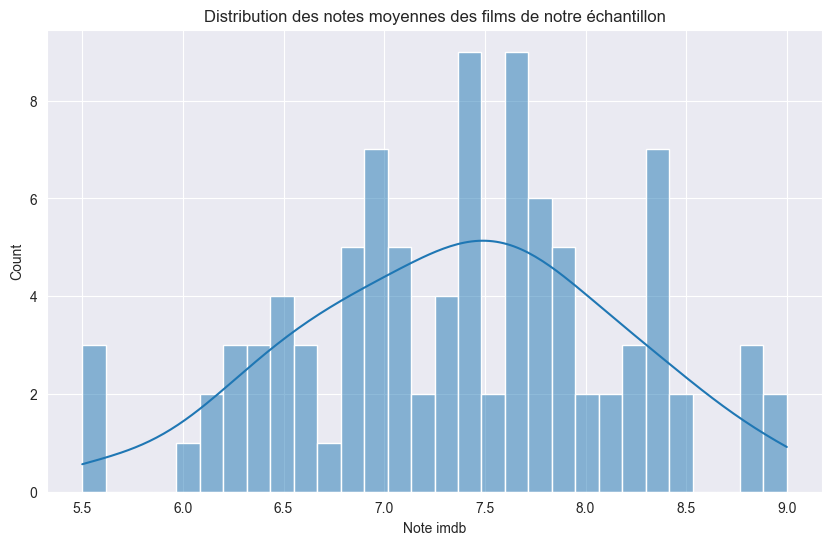

In [59]:
plt.figure(1, (10,6))
sns.histplot(x=df.groupby('Film')['Note imdb'].mean(),kde=True, bins=30, palette="RdYlBu_r")
plt.title('Distribution des notes moyennes des films de notre échantillon')

**test de noramlité? Jarque berra**

#### **3.1.2** Budget et Box-Office

In [68]:
# Création des variables budget et box_office
budget = df['Budget'].unique()
box_office = df['Box office'].unique()

<Axes: xlabel='Box office'>

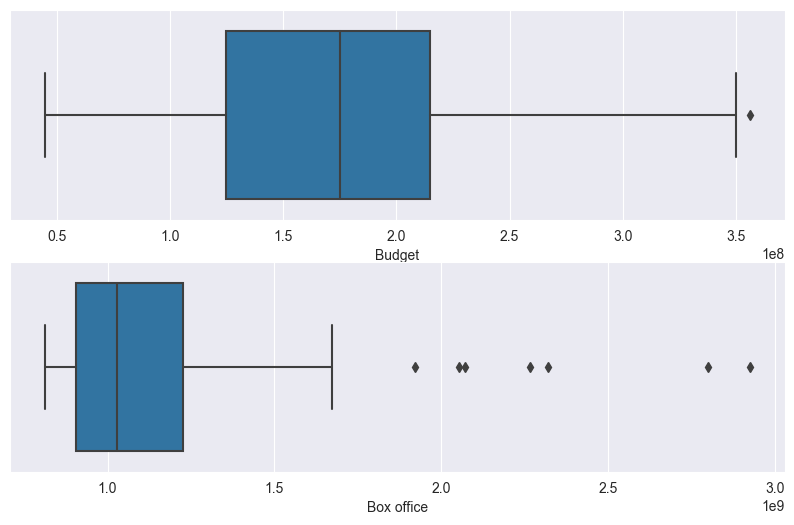

In [78]:
plt.figure(1, (10,6))

#1er boxplot
plt.subplot(2,1,1)
sns.boxplot(x=df.groupby('Film')['Budget'].mean())

#2eme boxplot
plt.subplot(2,1,2)
sns.boxplot(x=df.groupby('Film')['Box office'].mean())

regression théorique du BO sur le budget

In [83]:
Y.shape

(95,)

In [80]:
import statsmodels.api as sm 
X = budget
Y = box_office
#X = sm.add_constant(X)
model = sm.OLS(X,Y)
results = model.fit()
results.params


ValueError: endog and exog matrices are different sizes

# Un peu de Visualisation

In [ ]:
import seaborn as sns
sns.set_theme(style="darkgrid", palette="deep", color_codes=True)

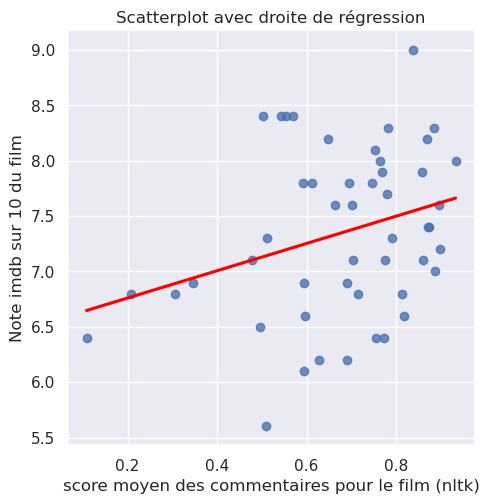

In [ ]:
# Affichez le nuage de points
sns.lmplot(x='sentiment_polarity_nltk', y='Note imdb', data=mean_by_group, line_kws={'color': 'red'}, ci=None)

# Ajout de titres et de labels
plt.title('Scatterplot avec droite de régression')
plt.xlabel('score moyen des commentaires pour le film (nltk)')
plt.ylabel('Note imdb sur 10 du film')

# Affichage du graphique
plt.show()

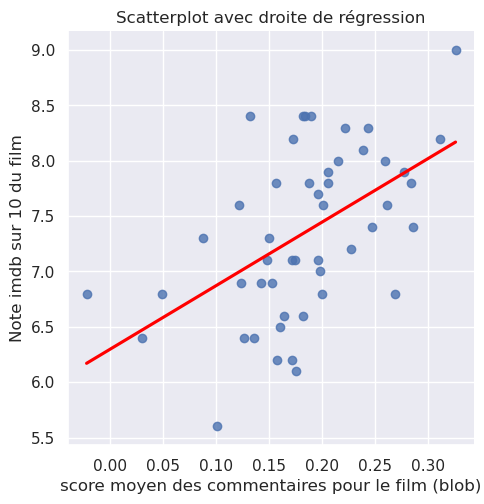

In [ ]:
# Affichez le nuage de points
sns.lmplot(x='sentiment_polarity_blob', y='Note imdb', data=mean_by_group, line_kws={'color': 'red'}, ci=None)

# Ajout de titres et de labels
plt.title('Scatterplot avec droite de régression')
plt.xlabel('score moyen des commentaires pour le film (blob)')
plt.ylabel('Note imdb sur 10 du film')

# Affichage du graphique
plt.show()

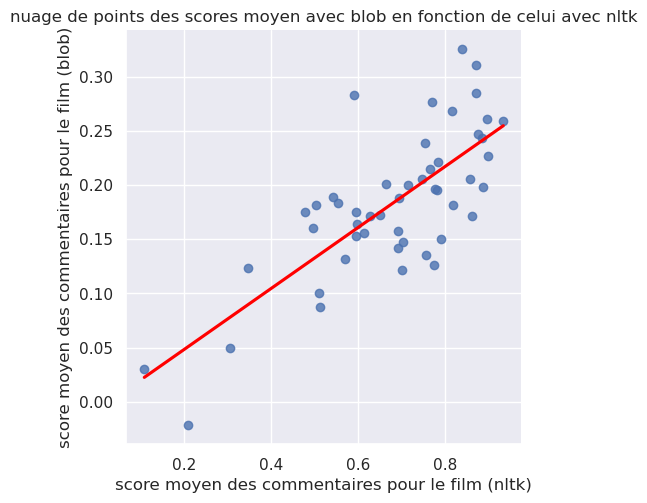

In [ ]:
# Affichez le nuage de points
sns.lmplot(x='sentiment_polarity_nltk', y='sentiment_polarity_blob', data=mean_by_group, line_kws={'color': 'red'}, ci=None)

# Ajout de titres et de labels
plt.title('nuage de points des scores moyen avec blob en fonction de celui avec nltk')
plt.xlabel('score moyen des commentaires pour le film (nltk)')
plt.ylabel('score moyen des commentaires pour le film (blob)')

# Affichage du graphique
plt.show()